<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [69]:
# Set your student number
student_number = 400101967
Name = 'Ehsan'
Last_Name = 'Merrikhi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [ ]:
# !pip install numpy
# !pip install matplotlib
# !pip install torchvision
# !pip install torch

## Importing Libraries

In [70]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [71]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [74]:
## FILL HERE

# one image dimension
image, label = train_set[0]
input_dim = image.view(-1).shape[0]
# number of classes
labels = []
idx = []
for index, (x, y) in enumerate(train_set):
  if y not in labels:
    labels.append(y)
    idx.append(index)
num_class, counts = np.unique(labels, return_counts=True)
num_classes = num_class.size

print('number of classes of first layer is: ' + str(num_classes))
print('number of pixels is: ' + str(input_dim))

number of classes of first layer is: 10
number of pixels is: 784


In [75]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

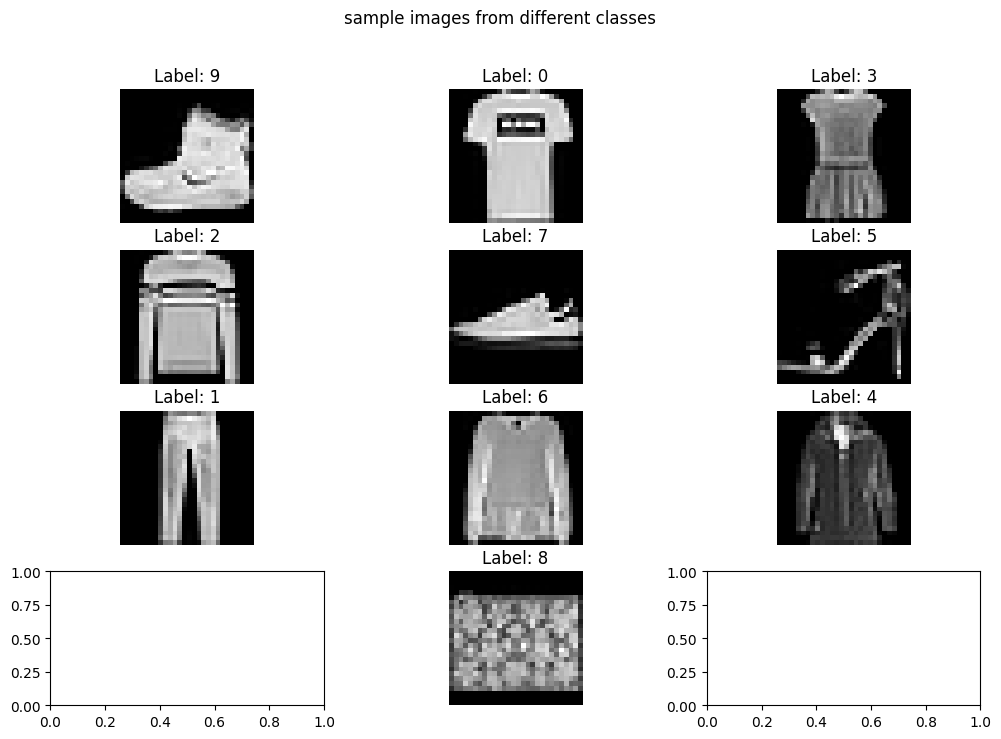

In [76]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

for i in range(4):
  for j in range(3):
    if(3*i + j > 9):
      break
    image, label = train_set[idx[3*i + j]]
    image_np = image.numpy().transpose((1, 2, 0)) if image.dim() == 3 else image.numpy()
    if (i == 3 and j == 0):
      ax[3, 1].imshow(image_np, cmap='gray')
      ax[3, 1].set_title(f'Label: {label}')
      ax[3, 1].axis('off')
    else:
      ax[i, j].imshow(image_np, cmap='gray')
      ax[i, j].set_title(f'Label: {label}')
      ax[i, j].axis('off')

fig.suptitle('sample images from different classes')
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [77]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [78]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [79]:
def affine_forward(x, w, b):
    ## FILL HERE
    return x @ w + b

def relu(x):
    ## FILL HERE
    return torch.maximum(x, torch.zeros_like(x))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [80]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)

    ## FILL HERE
    for i in range(num_layers):
      w = parameters[f'w{i}']
      b = parameters[f'b{i}']
      x = affine_forward(x, w, b)
      if i < (num_layers - 1):
          x = relu(x)
    output = x

    return output

Implementing cross entropy loss:

In [81]:
def cross_entropy_loss(scores, y):
    n = len(y)
    ## FILL HERE
    sftmx = torch.exp(scores) / torch.exp(scores).sum(dim=1, keepdim = True)
    log_probs = torch.log(sftmx[range(n), y])
    loss = -log_probs.sum() / n
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [82]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''
    This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, it zeros the gradients of the parameters after updating the parameter value.
    '''
    with torch.no_grad():
      for param_name, param in parameters.items():
          if param.grad is not None:
              param.data -= learning_rate * param.grad.data
              param.grad.zero_()

def zero_grad(parameters: Dict[str, torch.Tensor]):
    '''
    This function zeros out the gradients of the parameters.
    '''
    for param in parameters.values():
        if param.grad is not None:
            param.grad.zero_()

Training functions:

In [83]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    return (y_pred == y_true).mean()

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []


    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE

        # Compute loss
        loss = cross_entropy_loss(p, y)
        loss.backward()
        sgd_optimizer(parameters, learning_rate)

        train_loss += loss.item() * x.size(0)


        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item() * x.size(0)

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [84]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [85]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    # train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        # Train the model for one epoch
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate the model on the test set
        test_loss, test_acc = validate(test_loader, epoch, set_name='Test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    # Plot the loss history of training and test sets
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.show()

    # Plot the accuracy history of training and test sets
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.show()


Accuracy of train set: 0.35465
Accuracy of Test set: 0.465
Accuracy of train set: 0.365
Accuracy of Test set: 0.29313333333333336
Accuracy of train set: 0.4354166666666667
Accuracy of Test set: 0.5754
Accuracy of train set: 0.6354833333333333
Accuracy of Test set: 0.6885666666666667
Accuracy of train set: 0.70815
Accuracy of Test set: 0.7367
Accuracy of train set: 0.7459666666666667
Accuracy of Test set: 0.7524666666666666
Accuracy of train set: 0.7641666666666667
Accuracy of Test set: 0.7775833333333333
Accuracy of train set: 0.77985
Accuracy of Test set: 0.7656166666666666
Accuracy of train set: 0.7924833333333333
Accuracy of Test set: 0.7833333333333333
Accuracy of train set: 0.80145
Accuracy of Test set: 0.8063
Accuracy of train set: 0.8091333333333334
Accuracy of Test set: 0.8079
Accuracy of train set: 0.8160333333333334
Accuracy of Test set: 0.80965
Accuracy of train set: 0.8206333333333333
Accuracy of Test set: 0.8278666666666666
Accuracy of train set: 0.8256333333333333
Accurac

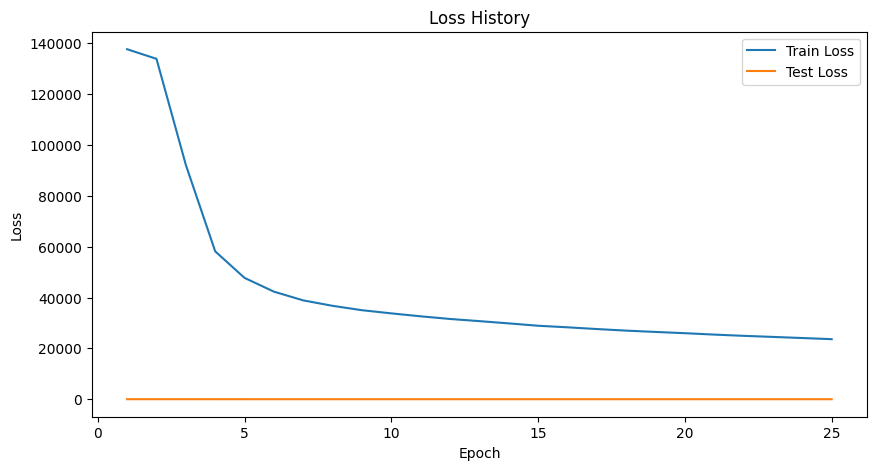

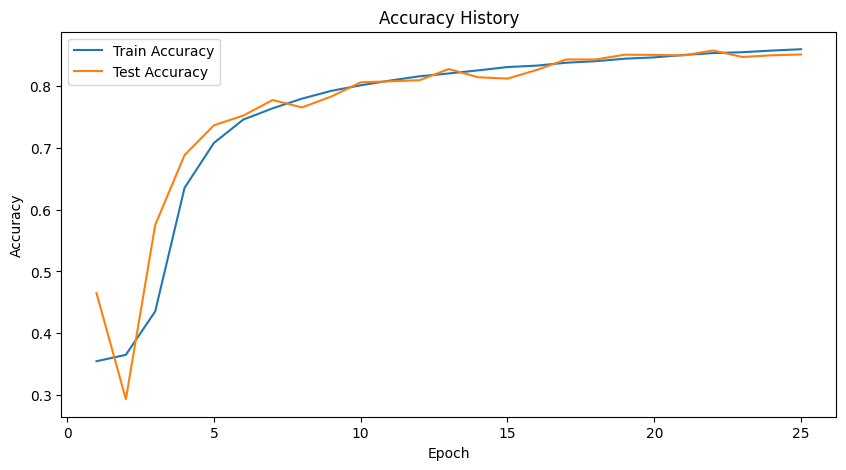

In [86]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [88]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8513833333333334


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

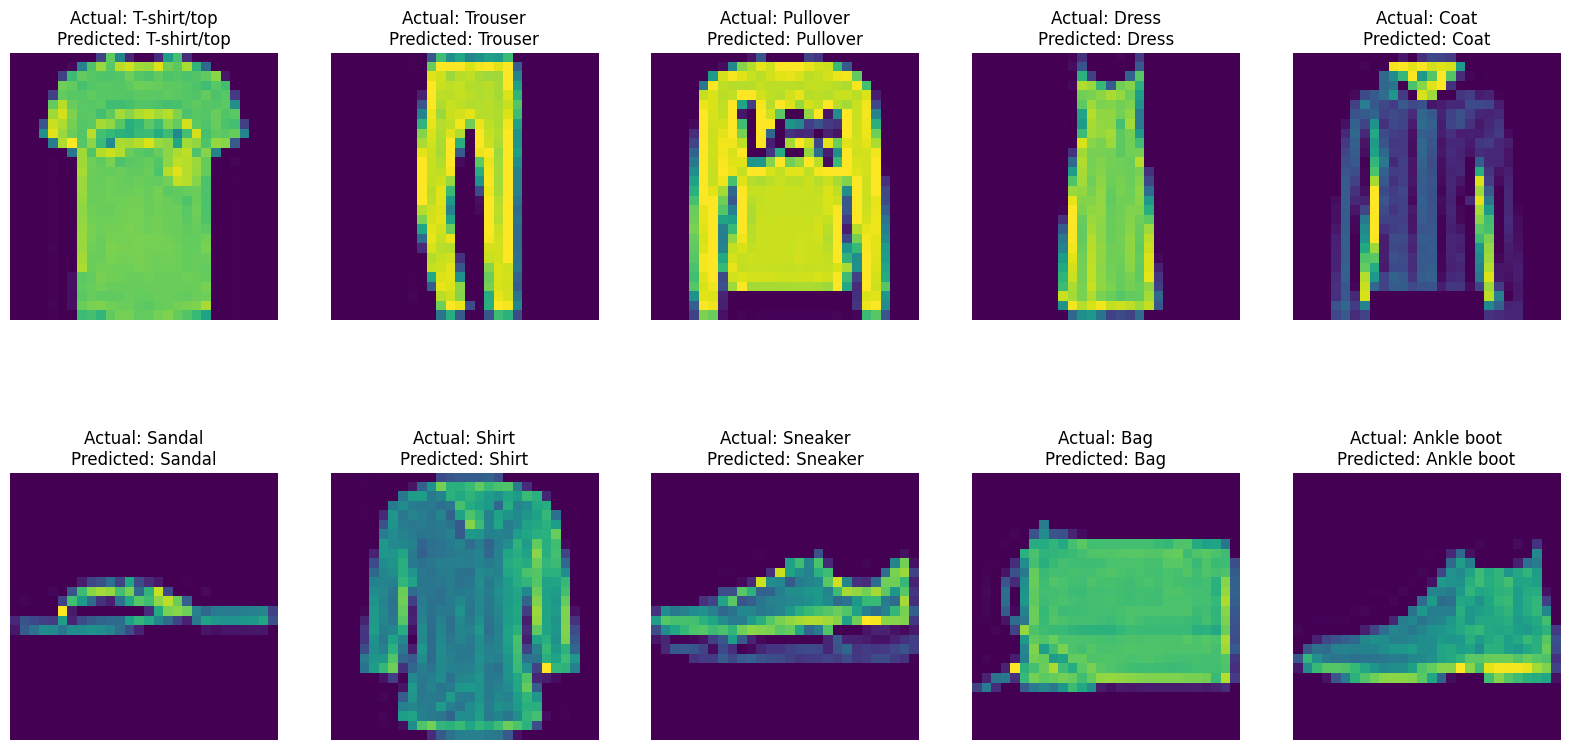

In [90]:
imgs = {}
for i in range(num_classes):
    idx = np.where(np.array(test_set.targets) == i)[0][0]  # Convert to numpy array to use np.where
    imgs[i] = test_set[idx][0]

# Convert class_images to a tensor
imgs_tensor = torch.stack(list(imgs.values()))

# Make predictions using the trained model
with torch.no_grad():
    class_predictions = model(imgs_tensor.to(device), parameters)  # Removed parameters since typically model() should only take input tensor

# Get the predicted labels
predicted_labels = torch.argmax(class_predictions, dim=1).cpu().numpy()

# Plot the images with actual and predicted labels
plt.figure(figsize=(20, 10))
for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i].permute(1, 2, 0))  # Removed cmap='gray' for RGB images, add back if images are grayscale
    plt.title(f"Actual: {test_set.classes[i]}\nPredicted: {test_set.classes[predicted_labels[i]]}")
    plt.axis('off')
plt.show()

In [68]:
%reset -f